In [6]:
import cv2
from skimage import color
import sys
import torch
from torchvision import transforms
from skimage import color
from PIL import Image
sys.path.append('./utils')
from color_quantization import NNEncode
from matplotlib import pyplot as plt
from matplotlib import image
import scipy.ndimage.interpolation as sni

import numpy as np

sys.path.append('./models')
from colorization_deploy_v1 import colorization_deploy_v1

In [15]:
sigma = 5
nb_neighboors = 10
model = torch.load("./../base.pt")

In [11]:
def plot(im, interp=False):
    f = plt.figure(figsize=(5,10), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

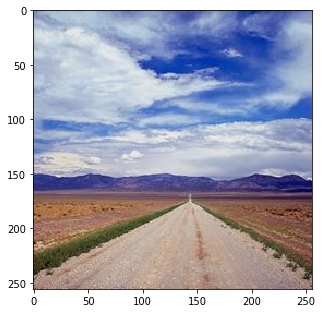

In [16]:
img_rgb = Image.open("./utils/sun.jpg")
plot(img_rgb)

In [17]:
img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel
(H_orig,W_orig) = img_rgb.size[:2] # original image size

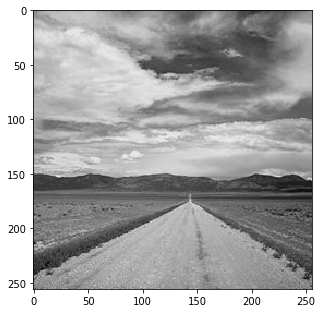

In [18]:
# create grayscale version of image (just for displaying)
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)
plot(img_rgb_bw)

In [19]:
mean_img_l = torch.as_tensor(img_l-50, dtype=torch.float32)
mean_img_l.unsqueeze_(0).unsqueeze_(0)
mean_img_l.shape

torch.Size([1, 1, 256, 256])

In [20]:
pred_ab = model(mean_img_l).squeeze(0)
d=pred_ab.detach().numpy().transpose((1,2,0))
print(d.shape)

(64, 64, 2)


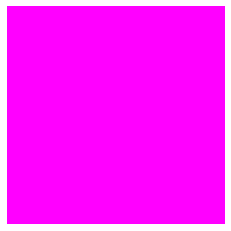

In [22]:
ab_dec_us = sni.zoom(d,(4,4,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_rgb_out = np.clip(color.lab2rgb(2*img_lab_out-128),0,1) # convert back to rgb

plt.imshow(img_rgb_out);
plt.axis('off');

In [87]:
#rgb = transforms.Resize((256,256), Image.BICUBIC)(rgb)
rgb = np.array(rgb)
#print(rgb.shape)
Lab = color.rgb2lab(rgb).astype(np.float32).transpose(2,0,1)
l = Lab[0,:,:][np.newaxis, ...]
print(l)

[[[59.71528  60.857876 61.23785  ... 56.104305 58.46636  59.5331  ]
  [61.049694 61.23785  60.669334 ... 58.84894  60.374756 61.43605 ]
  [59.326633 59.52556  58.760765 ... 60.295616 61.81531  62.19414 ]
  ...
  [60.844078 55.85493  56.651306 ... 50.87313  40.1987   25.39901 ]
  [54.71556  57.422165 57.422165 ... 57.69391  60.75448  57.483673]
  [54.71556  49.62223  39.552906 ... 56.820293 56.868393 52.65205 ]]]


In [86]:
lab2= color.rgb2lab(rgb)
lab2[:,:, 1:3]=0
plot(color.lab2rgb(lab2))
        
tr = model(torch.as_tensor(l))
#tr = nnenc.decode_points_mtx_nd(tr.detach().numpy())
tr = sni.zoom(tr,(4,4,1))
print(tr.shape)

g= tr[0,:,:,:].transpose(1,2, 0)

img_lab = color.rgb2lab(rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel

img_lab_out = np.concatenate((img_l[:,:,np.newaxis],g),axis=2)

img_rgb_out = np.clip(color.lab2rgb(img_lab_out),0,1) # convert back to rgb

plot(img_rgb_out)


[[[59.71528  60.857876 61.23785  ... 56.104305 58.46636  59.5331  ]
  [61.049694 61.23785  60.669334 ... 58.84894  60.374756 61.43605 ]
  [59.326633 59.52556  58.760765 ... 60.295616 61.81531  62.19414 ]
  ...
  [60.844078 55.85493  56.651306 ... 50.87313  40.1987   25.39901 ]
  [54.71556  57.422165 57.422165 ... 57.69391  60.75448  57.483673]
  [54.71556  49.62223  39.552906 ... 56.820293 56.868393 52.65205 ]]]


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 1 3, but got 3-dimensional input of size [1, 256, 256] instead